# Importation des modules et packages

### Webscrapping et importation des données

In [2]:
!pip install lxml
import requests 
import urllib
import bs4
import pandas as pd
from urllib import request
import re
from tqdm import tqdm
from scipy import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 18.2 MB/s eta 0:00:0000:0100:01


### Visualisation et analyse des données

In [3]:
# Lecture et traitement du dataframe
import pandas as pd 
import numpy as np 

# Rapport sur les données pandas :
!pip install pandas_profiling 
!pip install ipywidgets
from pandas_profiling import ProfileReport

# Visualisation et analyse graphique des données
import matplotlib.pyplot as plt

# Visualisation et analyse cartographique des données
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install geopandas
import geopandas as gpd
import contextily as ctx

# Corrélation entre les données
import seaborn as sns 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 7.0 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.0 MB/s eta 0:00:0000:0100:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=923ae09e19a31a8158870f397b3ce3bf38b4301f7c33cb42a3ad139ce241b26f
  Stored in directory: /home/onyxia/.cache/pip/wheels/ea/1c/a8/5cec3479cd45136a7111e2d96aac299b219b199c411665250b
Successfully built htmlmin
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 4.8 MB

### Modélisation

In [4]:
# Pour normaliser les données, on choisit MinMaxScaler de la librairie Sklearn
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

#
from sklearn.linear_model import Ridge

#
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, explained_variance_score

----------------------------------------------------------------------------------------------------------------

# Récupération des données 

## WebScrapping des noms de films sur Wikipédia 

On stocke tous les noms des films présents sur cette page https://en.wikipedia.org/wiki/List_of_years_in_film dans une liste que l'on appelle Liste_films.
On modifie le format de certains titre : ' XXX (1967)' devient ' XXX '.\
Finalement, on récupère la longueur de la liste : elle est de ≈ 1500. 

In [4]:
response = requests.get(
	url="https://en.wikipedia.org/wiki/List_of_years_in_film",
)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

List of years in film


In [5]:
all_names= soup.findAll("i")
L=[]
for link in all_names :
    t=link.findAll('a')
    if len(t)!=0:
        r=t[0]['title']
        L.append(r)
# print(L)

On enlève les précisions entre parenthèses 

In [6]:
Liste_films= []
for i in L: 
    Liste_films.append(re.sub("\(.*?\)","()",i).replace("()",""))
#print(L2)
print(len(Liste_films), Liste_films[:10])

1542 ['The Matrix', 'Passage de Vénus', 'The Horse in Motion', 'Man Walking Around a Corner', 'The First Film', 'Roundhay Garden Scene', 'Roundhay Garden Scene', "London's Trafalgar Square", 'Monkeyshines', 'Dickson Greeting']


## Utilisation d'une API pour récupérer l'identifiant des films à partir de leur titre

On utilise l'API: The Movie Database API (TMDB API) pour laquelle nous avons dû faire une demande de clé : api_key\
On place ces identifiants dans une liste index.
En effet, pour pouvoir accéder aux informations des films, TMDB nous demande l'identifiant de chacun des films. Or nous n'avons que les titres des films scrappés. 
Cette étape est donc essentielle pour la création de notre dataset. 

### Cas particulier : on fixe le nom du film

On va utiliser une première requête d'API pour accéder aux ID des films scrappés sur Wikipédia.

In [7]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 
nom_du_film='Earth '

url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom_du_film}" 

#requête pour trouver les infos ayant le nom_du_film en title 
req = requests.get(url_api)
wb = req.json()

# on récupère tous les indexs des films en question 
index=[]
for film in range(len(wb['results'])):
    index.append(wb['results'][film]['id'])
index  

[811367,
 82700,
 443297,
 55420,
 10946,
 5491,
 10176,
 31642,
 16300,
 13363,
 748853,
 11569,
 2210,
 88751,
 85949,
 641370,
 197624,
 464593,
 347111,
 238603]

##### Création d'une fonction qui renvoie, à titre fixé, tous les index des films scrappés sur Wikipedia.

In [8]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API TMDB

def get_id(nom):
    url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom}" 
    #requête pour trouver les infos ayant le nom_du_film en title 
    req = requests.get(url_api)
    wb = req.json()


    # on récupère tous les indexs des films en question 
    index=[]
    for film in range(len(wb['results'])):
        index.append(wb['results'][film]['id'])
    return(index)



##### Récupération du détail des données grâce à une autre API 

Toujours sur TMDB API, on utilise cette fois l'identifiant du film pour accéder à un grand nombre de données sur ce film : get detail. 
Pour cela on fait appel à la fonction précédente qui nous donnait les id correspondant au titre du film. 
On ajuste le format des données pour que les tailles des éléments nous permettent de convertir le dictionnaire
en DataFrame pandas. 

In [9]:
def df_avec_id(id):
    id_film= id
    url_new_api = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={api_key}&language=en-US"
    req_new = requests.get(url_new_api)
    wb_new = req_new.json()
    
    
    #ajustement des données 
    if wb_new['belongs_to_collection']!=None: 
        wb_new['belongs_to_collection']=wb_new['belongs_to_collection']['name']
        
    wb_new['genres']=' , '.join([x['name'] for x in wb_new['genres']]) #on ne sélectionne que le nom des genres car l'API nous donne un tableau (impossible à exploiter dans un dataframe)
    wb_new['production_companies']=' , '.join([x['name'] for x in wb_new['production_companies']]) #on ne sélectionne que les noms (même pas les pays)
    wb_new['production_countries']=' , '.join([x['name'] for x in wb_new['production_countries']])
    wb_new['spoken_languages']=' , '.join([x['name'] for x in wb_new['spoken_languages']])
    
    df=pd.DataFrame(wb_new, index=[wb_new['id']])  #j'ai mis l'ID en index mais on peut aussi indexer à partie de 0
    # pour cela, on met index=[0]
    
    return (df)

### Généralisation et concaténation

On utilise les deux fonctions précédentes pour créer notre DataFrame all. 
On parcourt la liste des titres puis la liste des id pour chacun des films. 
On a donc une double-boucle for, ce qui s'avère couteux mais qui fonctionne après 45 min environ. 

Un axe d'amélioration serait de réduire le temps pour cette collecte de données. 

In [10]:
def concat_all(liste):
    Liste_fail=[]
    
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        for i in ind:
            try:
                df_2=df_avec_id(i)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    DF_ALL=pd.concat([DF_ALL,df_2],axis=0)
                    
            except ValueError:
                Liste_fail.append([nom,i])
    print(Liste_fail)
    return DF_ALL

In [11]:
def concat_all_2(liste):
    Liste_fail=[]
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        f_vect(ind)
    print(Liste_fail)
    return DF_ALL

In [12]:
def fonction_int(id):
    try:
                df_2=df_avec_id(id)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    return(pd.DataFrame())
                    
    except ValueError:
                Liste_fail.append(id)
            

f_vect = np.vectorize(fonction_int)

In [13]:
l=Liste_films
a=concat_all(l)

100%|██████████| 1542/1542 [36:57<00:00,  1.44s/it] 

[]


## Création d'un fichier .csv
On va exporter ce fichier en csv pour ne pas à recharger à chaque fois car le chargement est chronophage (temps estimé : 30 à 45 minutes).

On enregistre le Dataframe all sous un fichier au format csv.

In [14]:
a.to_csv('Projet_films.csv',index=False) 

On vient charger le fichier 'Projet_films.csv' dans notre code pour pouvoir l'exploiter ensuite.

In [5]:
df=pd.read_csv('Projet_films.csv')
df.head(5)

Unnamed: 0  adult                     backdrop_path  belongs_to_collection  \
0      624860  False  /eNI7PtK6DEYgZmHWP9gQNuff8pv.jpg  The Matrix Collection   
1         603  False  /l4QHerTSbMI7qgvasqxP36pqjN6.jpg  The Matrix Collection   
2         604  False  /pxK1iK6anS6erGg4QePmMKbB1E7.jpg  The Matrix Collection   
3         605  False  /533xAMhhVyjTy8hwMUFEt5TuDfR.jpg  The Matrix Collection   
4       13764  False  /xLDSKsyAGFFCNYDmNynEOsms5jp.jpg                    NaN   

      budget                                           genres  \
0  190000000             Science Fiction , Action , Adventure   
1   63000000                         Action , Science Fiction   
2  150000000  Adventure , Action , Thriller , Science Fiction   
3  150000000  Adventure , Action , Thriller , Science Fiction   
4   50000000                     Family , Fantasy , Adventure   

                           homepage      id     imdb_id original_language  \
0   https://www.whatisthematrix.com  624860  tt10838180                en   
1  http://www.warnerbros.com/matrix     603   tt0133093                en   
2                               NaN     604   tt0234215                en   
3                               NaN     605   tt0242653                en   
4                               NaN   13764   tt0089961                en   

   ... release_date    revenue  runtime    spoken_languages    status  \
0  ...   2021-12-16  156497322      148             English  Released   
1  ...   1999-03-30  463517383      136             English  Released   
2  ...   2003-05-15  738599701      138             English  Released   
3  ...   2003-11-05  424988211      129  English , Français  Released   
4  ...   1985-10-29   23717291      108             English  Released   

                                       tagline                     title  \
0                        Return to the source.  The Matrix Resurrections   
1                   Welcome to the Real World.                The Matrix   
2                              Free your mind.       The Matrix Reloaded   
3  Everything that has a beginning has an end.    The Matrix Revolutions   
4                  Guess who's coming to town!    Santa Claus: The Movie   

   video  vote_average vote_count  
0  False         6.587       4301  
1  False         8.193      22349  
2  False         7.025       9410  
3  False         6.699       8457  
4  False         6.300        205  

[5 rows x 26 columns]

----------------------------------------------------------------------------------------------------------------

# Visualisation et analyse des données

On va utiliser ProfileReport pour faire une rapide analyse de données. 
Grâce à ce ProfileReport, on va accéder aux nombres valeurs manquantes (NaN) par variables, mais aussi aux différentes valeurs prises par chacune des variables. Enfin, on a accès à la heatmap qui nous donne une première indication concernant les variables importantes pour notre prédiction de revenu. 
La variable revenu étant la Target, nous allons regarder quelles sont les variables corrélées à cette dernière grâce à la heatmap. 

On obtient un rapport beaucoup plus précis que df.describe()

In [7]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Interprétation 
Une première analyse est que la variable adulte n'a aucun intérêt puisqu'elle prend tout le temps la valeur 1. 
En vue de notre prédiction de revenue, cette dernière s'avère donc inutile. 

# Nettoyage des données 

### Variables utiles
 
On commence par chercher les variables utiles pour notre analyse des données puis pour notre modèle de prédiction. 

D'après le Profile Report du début, on observe que tous les films sont classés "Adult", cette variable n'a donc ici que peu d'intérêt. 
On fait le choix de ne pas prendre en compte les variables suivantes pour notre modèle:
- adult 
- backdrop_path
- homepage
- id 
- imdb_id
- original title
- overview
- poster_path 

In [8]:
df.columns

Index(['Unnamed: 0', 'adult', 'backdrop_path', 'belongs_to_collection',
       'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count'],
      dtype='object')

In [9]:
df_bis= df[['belongs_to_collection','budget','genres','original_language','production_countries','popularity','production_companies','release_date','revenue','runtime','spoken_languages','status','vote_average','vote_count']]

On ne garde que les films qui sont sortis et dont le revenu et le runtime sont strictement positifs.


In [10]:
df_bis=df_bis[df_bis.status=='Released']
df_bis= df_bis[df_bis.runtime!=0]
df_bis = df_bis[df_bis['revenue'] > 0]

On change le type des dates maintenant, il s'agit bien de datetime et pas d'un string : 

In [11]:
df_bis.release_date=pd.to_datetime(df_bis.release_date, format='%Y-%m-%d', errors = 'ignore')

In [12]:
df_bis['release_year']=df_bis['release_date'].dt.year 
df_bis['release_month']=df_bis['release_date'].dt.month 
df_bis['release_day']=df_bis['release_date'].dt.day 

On enlève les warnings causés pas le .iloc 

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Résolution des problèmes du dataset
On travaille à présent sur les variables (genres, production countries...) de manière à obtenir un jeu de données propre et exploitable. Pour cela, on va créer pour chaque genre une variable "Nom_du_Genre" ("Action" par exemple) qui vaudra 1 si le film appartient à ce genre et 0 sinon. De même pour la nationalité. Et enfin, de même pour la saga (créer une variable qui prend la valeur 1 si le film est une saga, 0 sinon).

#### La variable 'genre'
On va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le problème de la multiappartenance. En effet, actuellement un film peut avoir pour genre "Action, Adventure, Drama" et n'a donc pas le "même" genre qu'un autre film "Action, Adventure, Mystery". 

In [1020]:
#On va créer une liste contenant tous les genres du dataset

Liste_genres= df_bis['genres'].unique()
p = re.compile(r'\W+')

Liste_finale=[]

for i in Liste_genres : 
    #print(str(i))
    sous_liste= p.split(str(i))
    for j in sous_liste :
        Liste_finale.append(j)
        
Liste_genre_finale = list(np.unique(Liste_finale))     
Liste_genre_finale.append('Science Fiction')
Liste_genre_finale.remove('Science')
Liste_genre_finale.remove('Fiction')
Liste_genre_finale.remove('nan')
Liste_genre_finale #cette liste contient tous les genres différents présents dans le dataset

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Movie',
 'Music',
 'Mystery',
 'Romance',
 'TV',
 'Thriller',
 'War',
 'Western',
 'Science Fiction']

In [1021]:
# Pour chaque genre on crée une variable qui vaut 1 ou 0 en fonction de l'appartenance à ce genre 
for genre in Liste_genre_finale:
    df_bis[genre]= df_bis['genres'].str.contains(genre, case=False).astype(bool).astype(int)
df_bis.head(5)

belongs_to_collection     budget  \
0  The Matrix Collection  190000000   
1  The Matrix Collection   63000000   
2  The Matrix Collection  150000000   
3  The Matrix Collection  150000000   
4                    NaN   50000000   

                                            genres original_language  \
0             Science Fiction , Action , Adventure                en   
1                         Action , Science Fiction                en   
2  Adventure , Action , Thriller , Science Fiction                en   
3  Adventure , Action , Thriller , Science Fiction                en   
4                     Family , Fantasy , Adventure                en   

       production_countries  popularity  \
0  United States of America     213.259   
1  United States of America      77.938   
2  United States of America      40.939   
3  United States of America      37.752   
4  United States of America      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime  ... Sweden Switzerland  Taiwan  Turkey  Ukraine  \
0      148  ...      0           0       0       0        0   
1      136  ...      0           0       0       0        0   
2      138  ...      0           0       0       0        0   
3      129  ...      0           0       0       0        0   
4      108  ...      0           0       0       0        0   

   United Arab Emirates  United Kingdom  United States of America  Vietnam  \
0                     0               0                         1        0   
1                     0               0                         1        0   
2                     0               0                         1        0   
3                     0               0                         1        0   
4                     0               0                         1        0   

   Science Fiction  
0                1  
1                1  
2                1  
3                1  
4                0  

[5 rows x 99 columns]

#### La variable 'production_countries'
On fait de même qu'avec les genres : on va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le problème de la multiappartenance.

In [1022]:
Liste_pays_prod= df_bis['production_countries'].unique()
Liste_production=[]

for i in Liste_pays_prod : 
    #print(str(i))
    sous_liste= re.split(' ; | , ', str(i))
    for j in sous_liste :
        Liste_production.append(j)
        
Liste_production = np.unique(Liste_production)     
Liste_production

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'China',
       'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'India', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico',
       'Morocco', 'Netherlands', 'New Zealand', 'Norway', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Romania', 'Russia', 'Slovenia', 'South Africa', 'South Korea',
       'Soviet Union', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States of America', 'Vietnam', 'nan'], dtype='<U24')

In [1023]:
for pays in Liste_production:
    df_bis[pays]= df_bis['production_countries'].str.contains(pays, case=False).astype(bool).astype(int)
df_bis.head(5)

belongs_to_collection     budget  \
0  The Matrix Collection  190000000   
1  The Matrix Collection   63000000   
2  The Matrix Collection  150000000   
3  The Matrix Collection  150000000   
4                    NaN   50000000   

                                            genres original_language  \
0             Science Fiction , Action , Adventure                en   
1                         Action , Science Fiction                en   
2  Adventure , Action , Thriller , Science Fiction                en   
3  Adventure , Action , Thriller , Science Fiction                en   
4                     Family , Fantasy , Adventure                en   

       production_countries  popularity  \
0  United States of America     213.259   
1  United States of America      77.938   
2  United States of America      40.939   
3  United States of America      37.752   
4  United States of America      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime  ... Sweden Switzerland  Taiwan  Turkey  Ukraine  \
0      148  ...      0           0       0       0        0   
1      136  ...      0           0       0       0        0   
2      138  ...      0           0       0       0        0   
3      129  ...      0           0       0       0        0   
4      108  ...      0           0       0       0        0   

   United Arab Emirates  United Kingdom  United States of America  Vietnam  \
0                     0               0                         1        0   
1                     0               0                         1        0   
2                     0               0                         1        0   
3                     0               0                         1        0   
4                     0               0                         1        0   

   Science Fiction  
0                1  
1                1  
2                1  
3                1  
4                0  

[5 rows x 99 columns]

In [1024]:
# On crée un nouveau dataframe en enlevant les variables genres et production_countries
df_ter=df_bis.drop(['genres', 'production_countries'], axis=1, inplace = False)
df_ter.head(5)

belongs_to_collection     budget original_language  popularity  \
0  The Matrix Collection  190000000                en     213.259   
1  The Matrix Collection   63000000                en      77.938   
2  The Matrix Collection  150000000                en      40.939   
3  The Matrix Collection  150000000                en      37.752   
4                    NaN   50000000                en      11.490   

                                production_companies release_date    revenue  \
0  Village Roadshow Pictures , Warner Bros. Pictu...   2021-12-16  156497322   
1  Village Roadshow Pictures , Warner Bros. Pictu...   1999-03-30  463517383   
2  Village Roadshow Pictures , NPV Entertainment ...   2003-05-15  738599701   
3  Village Roadshow Pictures , NPV Entertainment ...   2003-11-05  424988211   
4  TriStar Pictures , Calash Corporation , GGG , ...   1985-10-29   23717291   

   runtime    spoken_languages    status  ...  Sweden  Switzerland  Taiwan  \
0      148             English  Released  ...       0            0       0   
1      136             English  Released  ...       0            0       0   
2      138             English  Released  ...       0            0       0   
3      129  English , Français  Released  ...       0            0       0   
4      108             English  Released  ...       0            0       0   

   Turkey  Ukraine  United Arab Emirates  United Kingdom  \
0       0        0                     0               0   
1       0        0                     0               0   
2       0        0                     0               0   
3       0        0                     0               0   
4       0        0                     0               0   

   United States of America  Vietnam  Science Fiction  
0                         1        0                1  
1                         1        0                1  
2                         1        0                1  
3                         1        0                1  
4                         1        0                0  

[5 rows x 97 columns]

#### La variable saga / 'b_to_c'
On crée une nouvelle variable b_to_c (belongs_to_collection) qui vaut 1 ou 0 en fonction de si le film appartient à une collection ou pas.


In [1025]:
df_ter['b_to_c']=pd.notnull(df_ter['belongs_to_collection']) #devient True et False
df_ter['b_to_c']=df_ter['b_to_c'].apply( lambda x : int(x))
df_ter.drop(['belongs_to_collection','production_companies','spoken_languages','status'], axis=1, inplace = True)
df_ter.head(5)

budget original_language  popularity release_date    revenue  runtime  \
0  190000000                en     213.259   2021-12-16  156497322      148   
1   63000000                en      77.938   1999-03-30  463517383      136   
2  150000000                en      40.939   2003-05-15  738599701      138   
3  150000000                en      37.752   2003-11-05  424988211      129   
4   50000000                en      11.490   1985-10-29   23717291      108   

   vote_average  vote_count  release_year  release_month  ...  Switzerland  \
0         6.592        4262        2021.0           12.0  ...            0   
1         8.193       22288        1999.0            3.0  ...            0   
2         7.025        9385        2003.0            5.0  ...            0   
3         6.699        8432        2003.0           11.0  ...            0   
4         6.264         203        1985.0           10.0  ...            0   

   Taiwan  Turkey  Ukraine  United Arab Emirates  United Kingdom  \
0       0       0        0                     0               0   
1       0       0        0                     0               0   
2       0       0        0                     0               0   
3       0       0        0                     0               0   
4       0       0        0                     0               0   

   United States of America  Vietnam  Science Fiction  b_to_c  
0                         1        0                1       1  
1                         1        0                1       1  
2                         1        0                1       1  
3                         1        0                1       1  
4                         1        0                0       0  

[5 rows x 94 columns]

#### La variable 'language'
On crée une nouvelle variable 'language' qui vaut 1 si la langue est parlée dans le film, 0 sinon.


In [1026]:
orig_language=pd.get_dummies(df_ter['original_language'],drop_first=True)

In [1027]:
Liste_des_langues = [i for i in orig_language.sum().sort_values(ascending=False).index[:5]]
Liste_des_langues.append('Others')
Liste_des_langues

['en', 'ja', 'fr', 'it', 'de', 'Others']

In [1028]:
for langue in Liste_des_langues:
    if langue!='Others':
        df_ter[langue + '_original']= df_ter['original_language'].str.contains(langue, case=False).astype(bool).astype(int)
    else: 
        df_ter[langue +  '_original']= df_ter["original_language"].apply(lambda x: x not in Liste_des_langues).astype(int)
    df_ter

In [1029]:
df_ter.drop(['original_language','release_date'], axis=1, inplace = True)

In [1030]:
df_ter.head(5)

budget  popularity    revenue  runtime  vote_average  vote_count  \
0  190000000     213.259  156497322      148         6.592        4262   
1   63000000      77.938  463517383      136         8.193       22288   
2  150000000      40.939  738599701      138         7.025        9385   
3  150000000      37.752  424988211      129         6.699        8432   
4   50000000      11.490   23717291      108         6.264         203   

   release_year  release_month  release_day  Action  ...  \
0        2021.0           12.0         16.0       1  ...   
1        1999.0            3.0         30.0       1  ...   
2        2003.0            5.0         15.0       1  ...   
3        2003.0           11.0          5.0       1  ...   
4        1985.0           10.0         29.0       0  ...   

   United States of America  Vietnam  Science Fiction  b_to_c  en_original  \
0                         1        0                1       1            1   
1                         1        0                1       1            1   
2                         1        0                1       1            1   
3                         1        0                1       1            1   
4                         1        0                0       0            1   

   ja_original  fr_original  it_original  de_original  Others_original  
0            0            0            0            0                0  
1            0            0            0            0                0  
2            0            0            0            0                0  
3            0            0            0            0                0  
4            0            0            0            0                0  

[5 rows x 98 columns]

In [1031]:
df_ter.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'release_year', 'release_month', 'release_day', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Movie', 'Music',
       'Mystery', 'Romance', 'Science', 'TV', 'Thriller', 'War', 'Western',
       'nan', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'China',
       'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Iran',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico', 'Morocco',
       'Netherlands', 'New Zealand', 'Norway', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Slovenia',
       'South Africa', 'South

# Visualisation et analyse graphique

### 1ère analyse naïve sur le Dataframe de départ df 

### Analyse de la répartition des données : description du dataset
Visualisons tout d'abord nos données brutes pour comprendre la répartition des films sélectionnés selon un certain nombre de critères.

#### Répartition dans le temps 

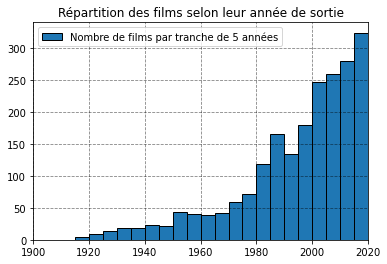

In [1032]:
%matplotlib inline
plt.hist(df_ter["release_year"], bins = [x for x in range(1900, 2025,5)] ,label = "Nombre de films par tranche de 5 années",
         ec = "black")
plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")
plt.xlim([1900,2020])
plt.title("Répartition des films selon leur année de sortie")
plt.legend()
plt.show()

On observe que le nombre de film dans notre dataset est croissant du temps. 

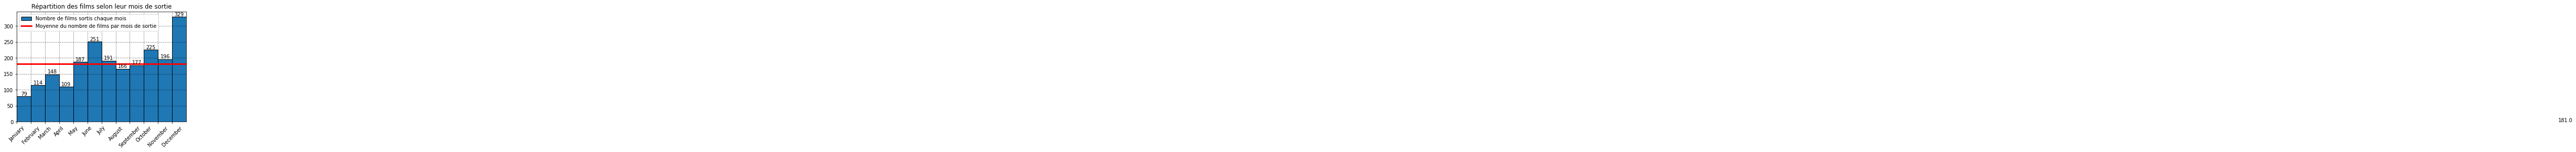

In [1033]:
x_axis_labels = ["January","February","March","April","May","June","July","August","September","October","November","December"]
            
counts, edges, bars = plt.hist(df_ter["release_month"], bins = [x for x in range(1, 14)] , label = "Nombre de films sortis chaque mois", ec = "black")
y = [df_ter.groupby(df_ter["release_month"]).size().mean() for x in range(2)]
plt.plot(np.linspace(0,13,2), y, color = "red", lw = 3, label = "Moyenne du nombre de films par mois de sortie")

plt.text(df_ter.groupby(df_ter["release_month"]).size().mean(), 0, df_ter.groupby(df_ter["release_month"]).size().mean())
plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")
plt.xlim([1,13])
plt.xticks(range(1,13), rotation = 45, labels = x_axis_labels)
plt.title("Répartition des films selon leur mois de sortie")
plt.bar_label(bars)
plt.legend()
plt.show() #double clic dessus si il s'affiche en petit

On observe une saisonnalité en fonction du mois de sortie du film. La plupart des films de notre dataset sont sortis durant les vacances d'été (juin-juillet). Néanmoins le pic est atteint avant Noël : au cours du mois de décembre. 

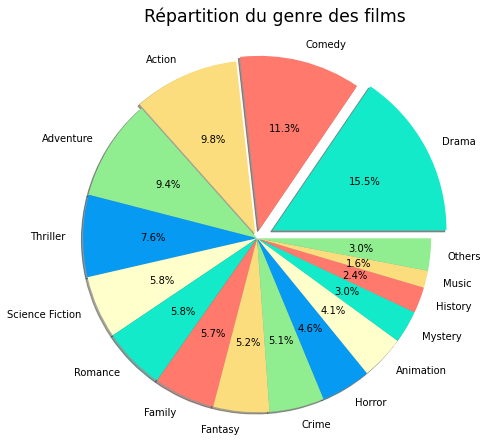

In [1037]:
L=[]
Genres=[]
for genre in Liste_genre_finale:
    l=0
    l=df_ter[genre].sum()
    L.append(l)
    Genres.append(genre)
#print(L) 
O=pd.DataFrame({'Count': L , 'Genre': Genres })
O.sort_values(by='Count', ascending=False, inplace=True)

DF=O[:15]
autre= O[15:].Count.sum()
Liste=list(DF.Count)
Liste.append(autre)
Labels=list(DF.Genre)
Labels.append("Others")

colors= ['#13EAC9','#FF796C','#FBDD7E','#90EE90','#069AF3','#FFFFCB']
myexplode = [0.2, 0.1, 0.05, 0,0,0,0,0,0,0,0,0,0,0,0,0]



plt.pie(Liste, labels = Labels, explode = myexplode, colors=colors ,autopct='%1.1f%%', startangle=0, shadow = True,
       radius=2)
plt.text(-1.3,2.5, "Répartition du genre des films", fontsize= 'xx-large')
plt.show() 

Notre dataset semble assez équilibré en termes de genres (5% pour les genres Romance, Family, Fantasy, Crime...) même si 15% des films appartiennent au genre Drama.

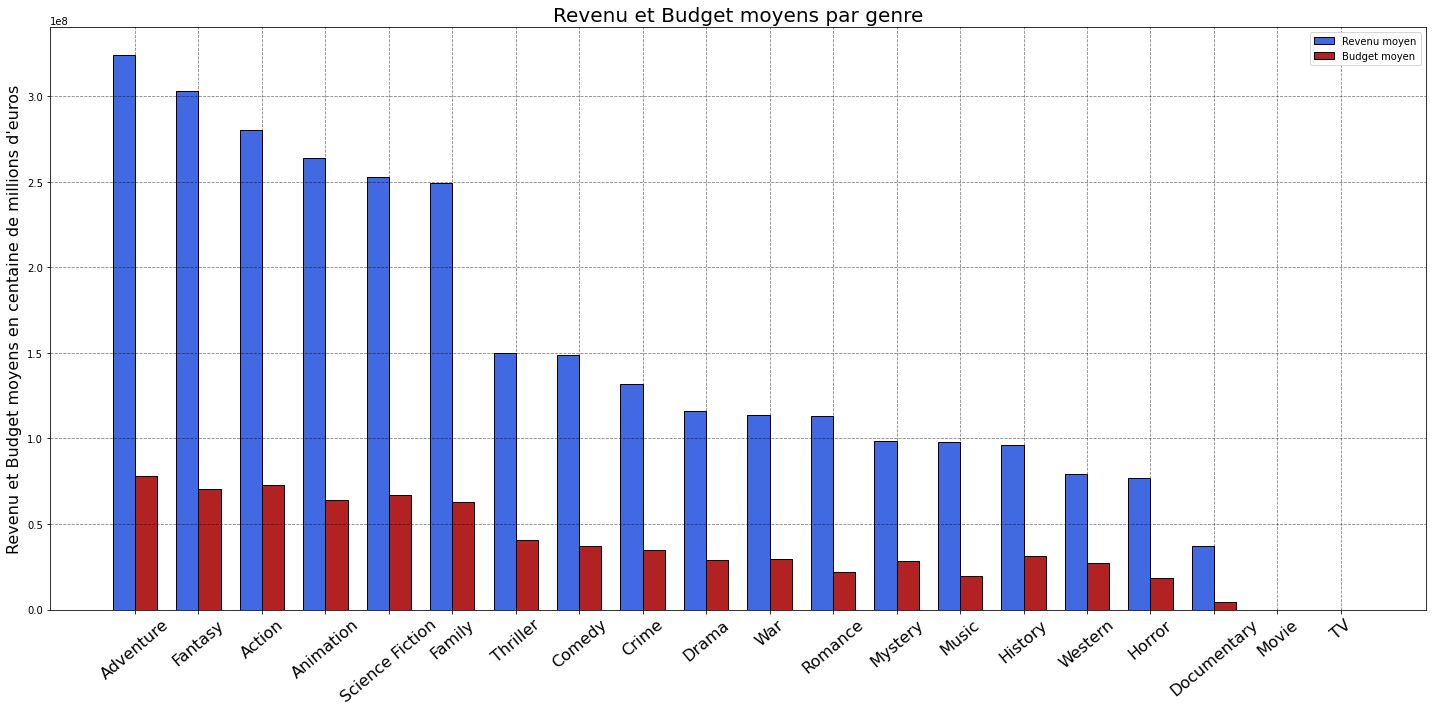

In [1036]:
y_revenue = []
y_budget = []
Liste = Liste_genre_finale[:len(Liste_genre_finale)]
for genre_name in Liste:
    y_revenue.append(df_ter.groupby(df_ter[genre_name])['revenue'].mean()[1])
    y_budget.append(df_ter.groupby(df_ter[genre_name])['budget'].mean()[1])
    
P=pd.DataFrame({'Revenue': y_revenue , 'Budget': y_budget, 'Genre': Liste })
P.sort_values(by='Revenue', ascending=False, inplace=True)

x = np.arange(len(Liste))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, P.Revenue, width, label='Revenu moyen', color='royalblue', edgecolor = "black")
rects2 = ax.bar(x + width/2, P.Budget, width, label='Budget moyen', color='firebrick', edgecolor = "black")
plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Revenu et Budget moyens en centaine de millions d'euros", labelpad=5, fontsize=16)
ax.set_title('Revenu et Budget moyens par genre', fontsize= 20)
ax.set_xticks(x)
ax.set_xticklabels(P.Genre, fontsize=16,  rotation=40)
ax.legend()

fig.tight_layout()

plt.show()

On observe que les genres Adventure, Fantasy, Action et Science - Fiction sont ceux générant le plus de revenu. Ils sont également ceux avec le plus gros budget. 
On peut déjà déduire de cet histogramme que le revenu est une fonction croissante du budget. 

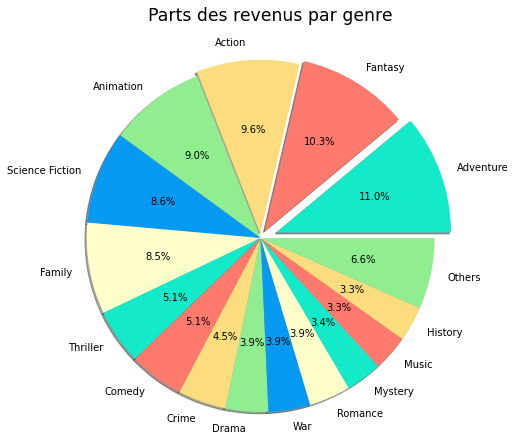

In [1068]:
L=[]
Genres=[]
for genre in Liste_genre_finale:
    l=0
    l=df_ter['revenue'][df_ter[genre]==1].mean()
    L.append(l)
    Genres.append(genre)
#print(L) 
O=pd.DataFrame({'Revenue_mean': L , 'Genre': Genres })
O.sort_values(by='Revenue_mean', ascending=False, inplace=True)

DF=O[:15]
autre= O[15:].Revenue_mean.sum()
Liste=list(DF.Revenue_mean)
Liste.append(autre)
Labels=list(DF.Genre)
Labels.append("Others")

colors= ['#13EAC9','#FF796C','#FBDD7E','#90EE90','#069AF3','#FFFFCB']
myexplode = [0.2, 0.1, 0.05, 0,0,0,0,0,0,0,0,0,0,0,0,0]



plt.pie(Liste, labels = Labels, explode = myexplode, colors=colors ,autopct='%1.1f%%', startangle=0, shadow = True,
       radius=2)
plt.text(-1.3,2.5, "Parts des revenus par genre", fontsize= 'xx-large')
plt.show() 

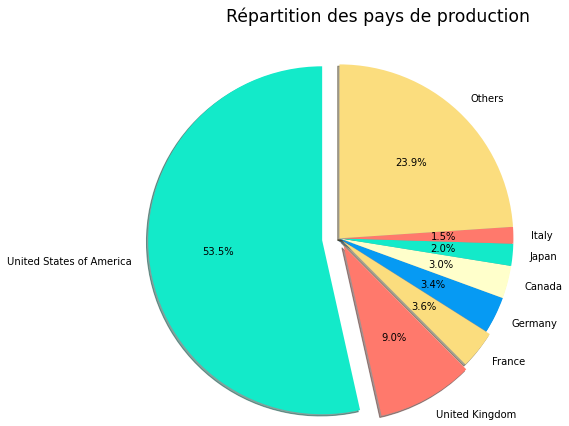

In [1038]:
L=[]
Pays=[]
for pays in Liste_production:
    l=0
    l=df_ter[pays].sum()
    L.append(l)
    Pays.append(pays)
#print(L) 
O=pd.DataFrame({'Count': L , 'Pays': Pays })
O.sort_values(by='Count', ascending=False, inplace=True)

DF=O[:7]
autre= O[7:].Count.sum()
Liste=list(DF.Count)
Liste.append(autre)
Labels=list(DF.Pays)
Labels.append("Others")

colors= ['#13EAC9','#FF796C','#FBDD7E','#069AF3','#FFFFCB']
myexplode = [0.2, 0.1, 0.05, 0,0,0,0,0]



plt.pie(Liste, labels = Labels, explode = myexplode, colors=colors ,autopct='%1.1f%%', startangle=90, shadow = True,
       radius=2)
plt.text(-1.3,2.5, "Répartition des pays de production", fontsize= 'xx-large')
plt.show() 

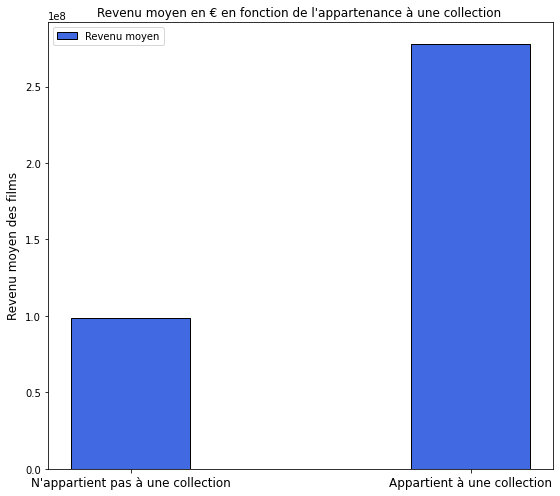

In [1039]:
x1 = ["N'appartient pas à une collection" , "Appartient à une collection"]
y_revenue= df_ter.groupby(df_ter['b_to_c'])['revenue'].mean()

x=np.arange(len(x1))
width= 0.35

fig, ax = plt.subplots(figsize=(8,7))
rects1= ax.bar(x, y_revenue, width, label='Revenu moyen', color='royalblue', edgecolor = "black")
ax.set_ylabel("Revenu moyen des films", labelpad=5, fontsize=12)
ax.set_title("Revenu moyen en € en fonction de l'appartenance à une collection ", fontsize= 12)
ax.set_xticks(x)
ax.set_xticklabels(x1, fontsize=12)
ax.legend()

fig.tight_layout()

plt.show()


### Liens entre les variables 

Après nettoyage des données, on revient sur l'analyse naïve avec notre premier dataframe non nettoyé (df).
On va essayer d'établir des corrélations entre les variables et notre variable revenu. 
On trace alors une Heatmap (plus complète que celle du ProfileReport ci-dessus) pour pouvoir accéder aux coefficients en déplacant le curseur sur cette Heatmap.

In [1040]:
import plotly.express as px

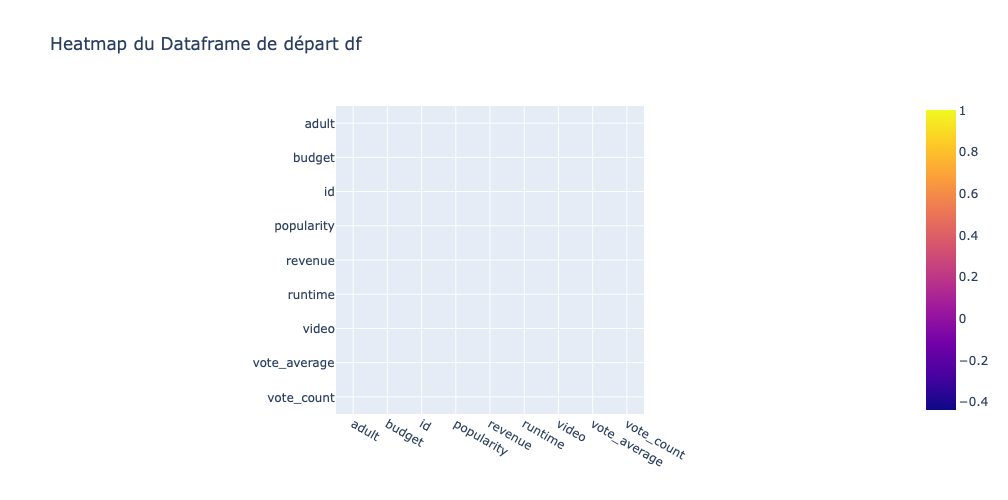

In [1041]:
fig = px.imshow(df.corr(), title='Heatmap du Dataframe de départ df',  width=500, height=500)
fig.show()

<AxesSubplot:>

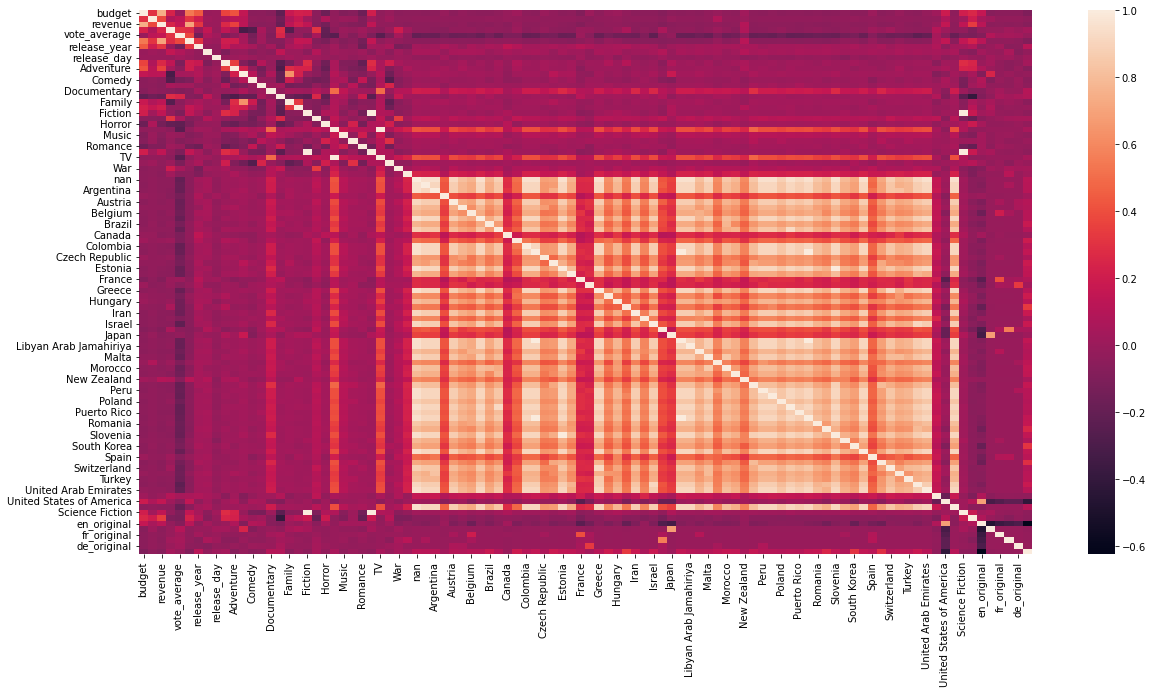

In [1042]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_ter.corr())


Les variables les plus corrélées avec le revenu semble à priori être le budget et le Vote_count. 

Regardons maintenant si l'on peut trouver des liens entre nos données descriptives et les revenus générés par les films sélectionnés (le revenu du film étant, dans la partie modélisation, ce que l'on cherchera à prédir).

Nous utilisons "xlim" et "ylim" pour écarter quelques valeurs extrêmes et avoir une vision plus claire de la plus grande partie de nos données.

Nous mettons aussi le revenu au logarithme pour limiter la dispersion de cette variable qui, dans nos données, s'échellone de quelques dizianes de milliers de dollars à plusieurs centaines de millions de dollars.

Les coefficients des droites de régression dites "potentielle" sont ici déterminée empiriquement en observant la répartition de données à l'aide de la formule du calcul de la pente d'une droite et en observant son ordonnée à l'origine. Tracer ces droites a ici pour but de convaincre de la pertinence de la régression linéaire que nous affectuerons sur ces données dans la dernière partie de ce projet. 

#### Lien Nombre de critiques reçues par le film - Chiffre d'affaires du film ?

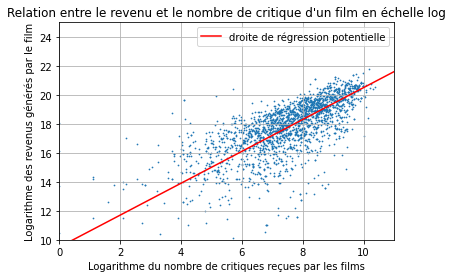

In [1044]:
plt.scatter(np.log(df_ter["vote_count"]), np.log(df_ter["revenue"]), s = 2, marker = ".")
plt.xlim([0,11])
plt.ylim([10,25])
plt.xlabel("Logarithme du nombre de critiques reçues par les films")
plt.ylabel("Logarithme des revenus générés par le film")
def f(x):
    return 1.1*x + 9.5
plt.plot([f(x) for x in range(30)], color = 'r', label = "droite de régression potentielle") 
plt.legend(loc='best')
plt.grid()
plt.title("Relation entre le revenu et le nombre de critique d'un film en échelle log")
plt.show()

On observe un lien qui semble linéaire entre le logarithme du nombre de critiques reçues par les films et le logarithme des revenus générés par les films de notre DataFrame. Una augmentation en pourcentage du nombre de critiques semble donc augmenter d'un certain pourcentage les revenus des films. 

#### Lien Budget de réalisation du film - Chiffre d'affaires du film ?

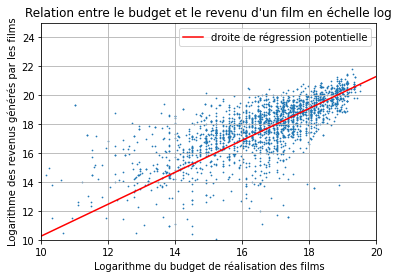

In [1045]:
plt.scatter(np.log(df_ter["budget"]), np.log(df_ter["revenue"]), s = 2, marker = ".")
plt.xlim([10,20])
plt.ylim([10,25])
plt.xlabel("Logarithme du budget de réalisation des films")
plt.ylabel("Logarithme des revenus générés par les films")
def f(x):
    return 1.1*x - 0.7
plt.plot([f(x) for x in range(30)], color = 'r', label = "droite de régression potentielle") 
plt.legend(loc='best')
plt.title("Relation entre le budget et le revenu d'un film en échelle log")
plt.grid()
plt.show()

De la même façon, on observe un lien qui semble linéaire entre le logarithme des budgets des films et le logarithme des revenus générés par les films de notre DataFrame. Una augmentation en pourcentage du budget semble donc augmenter d'un certain pourcentage les revenus des films. La dispersion semble de plus se réduire quand le budget augmente. Un film avec un budget important semble donc assurer un certain succès commercial à ce dernier.

#### Lien année de sortie du film - chiffre d'affaire du film

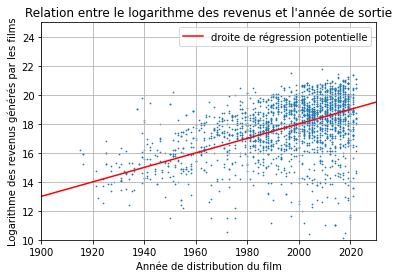

In [1046]:
plt.scatter(df_ter["release_year"], np.log(df_ter["revenue"]), s = 2, marker = ".")
plt.ylim([10,25])
plt.xlim([1900,2030])
plt.xlabel("Année de distribution du film")
plt.ylabel("Logarithme des revenus générés par les films")
def f(x):
    return 0.05*x - 82
plt.plot([f(x) for x in range(2500)], color = 'r', label = "droite de régression potentielle") 
plt.legend(loc='best')
plt.grid()
plt.title("Relation entre le logarithme des revenus et l'année de sortie")
plt.show()

On observe un lien qui semble linéaire entre l'année de distribution des films et le logarithme des revenus générés par les films. Les films plus récents semble donc générer un pourcentage plus élevé de revenus.


#### Évolution du Budget et du Revenu au cours du temps 

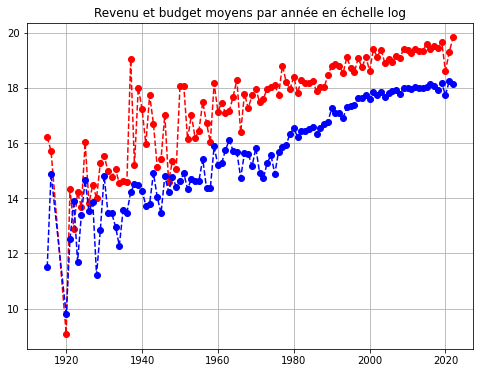

In [1047]:
x = df_ter['release_year'].sort_values().unique()[:len(df_ter['release_year'].sort_values().unique())-1] 
#liste des annnées possibles 
y = np.log(df_ter.groupby('release_year')['revenue'].mean())
#revenue moyen 

y_2 =np.log(df_ter.groupby('release_year')['budget'].mean())


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'ro--')
ax.plot(x, y_2, 'bo--')
#plt.legend('Revenue', 'Budget')
plt.title('Revenu et budget moyens par année en échelle log')
plt.grid()
plt.show()

## Visualisation et analyse cartographique des données

### Création de dataframes exploitables pour la cartographie
Pour visualiser les données sous forme de carte, on commence par transformer notre jeu de données.

Nous allons créer un `df_map_production_countries` qui :
* reprend les colonnes suivantes du df_ter 'revenue' (le chiffre d'affaires du film) et chacune des colonnes des pays de production
* permet d'identifier le chiffre d'affaire moyen d'un film en fonction de son pays de production au travers de la colonne (mean_revenu) et du pays associé

Nous allons ensuite fusionner le dataframe geopandas `world` disponible en opensource avec le  `df_map_production_countries` pour pouvoir au final tracer sur la carte du monde un classement des pays qui produisent les meilleurs films (en termes de chiffre d'affaires).

In [1048]:
df_map = df_ter.copy()
df_map['revenue']= np.log(df_map['revenue'])
df_map.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'release_year', 'release_month', 'release_day', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Movie', 'Music',
       'Mystery', 'Romance', 'Science', 'TV', 'Thriller', 'War', 'Western',
       'nan', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas',
       'Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'China',
       'Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Iran',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico', 'Morocco',
       'Netherlands', 'New Zealand', 'Norway', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Slovenia',
       'South Africa', 'South

#### On commence par créer le dataframe `df_map_production_countries`
Pour cela on sélectionne les colonnes de pays et chiffre d'affaires de chaque film, puis on associe à chaque pays le chiffre d'affaires moyen d'un film produit dans ce pays.

In [1049]:
df_map_1 = df_map[["revenue",'Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas','Belgium', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'China','Colombia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland','France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Iran','Ireland', 'Israel', 'Italy', 'Japan', 'Lebanon','Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico', 'Morocco','Netherlands', 'New Zealand', 'Norway', 'Peru', 'Philippines', 'Poland','Portugal', 'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Slovenia','South Africa', 'South Korea', 'Soviet Union', 'Spain', 'Sweden','Switzerland', 'Taiwan', 'Turkey', 'Ukraine', 'United Arab Emirates','United Kingdom', 'United States of America', 'Vietnam']]
df_map_production_countries = pd.DataFrame(columns=['mean revenue', 'country'])

In [1050]:
def mean_revenue(df_map_input, variable, df_map_outcome):
    df_country = df_map_input[df_map_input[variable]==1]
    mean_country = df_country['revenue'].sum()/len(df_country)
    df_map_outcome.loc[len(df_map_outcome)] = [mean_country , variable]
    return(df_map_outcome)

In [1051]:
df_map_production_countries = pd.DataFrame(columns=['Mean revenue', 'Country'])

countries=['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Botswana', 'Brazil', 
           'Bulgaria', 'Canada', 'China','Colombia', 'Cyprus', 'Czech Republic', 'Denmark','Estonia',
           'Finland','France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Iran', 'Ireland',
           'Israel', 'Italy', 'Japan', 'Lebanon','Libyan Arab Jamahiriya', 'Luxembourg', 'Malta', 'Mexico',
           'Morocco','Netherlands', 'New Zealand', 'Norway', 'Peru', 'Philippines', 'Poland','Portugal', 
           'Puerto Rico', 'Qatar', 'Romania', 'Russia', 'Slovenia','South Africa', 'South Korea', 'Soviet Union',
           'Spain', 'Sweden','Switzerland', 'Taiwan', 'Turkey', 'Ukraine', 'United Arab Emirates','United Kingdom',
           'United States of America', 'Vietnam']

for x in countries:
    mean_revenue(df_map_1, x, df_map_production_countries)
df_map_production_countries.head(5)

Mean revenue    Country
0      8.744917    Algeria
1      8.919552  Argentina
2     15.981251  Australia
3      9.846126    Austria
4     11.425340    Bahamas

#### On fusionne le dataframe `df_map_production_countries` et le dataframe geopandas `world`
Pour cela on importe le dataframe geopandas `world`et on ne garde que ce qui nous intéresse (à savoir le nom du pays et la géométrie associée pour tracer la carte).\
Puis, on fusionne le dataframe `df_map_production_countries` et le dataframe `world`\
On obtient bien la carte du monde avec en données le nom des pays et le chiffre d'affaires moyen par film par pays de production.

In [1052]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['Country'] = world['name']
world.drop(world.columns.difference(['geometry','Country']), 1, inplace=True)

In [1053]:
world_movies = pd.merge(world,df_map_production_countries, how='left', on=['Country'])
world_movies.head(5)

geometry  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

                    Country  Mean revenue  
0                      Fiji           NaN  
1                  Tanzania           NaN  
2                 W. Sahara           NaN  
3                    Canada     16.762175  
4  United States of America     17.832655

<AxesSubplot:>

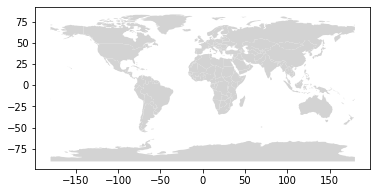

In [1054]:
world_movies.plot(color='lightgrey')

### Lien Pays de réalisation du film - Chiffre d'affaires du film ?
Ici, nous allons utiliser une échelle colorimétrique pour visualiser en un coup d'oeil la hiérarchie (en termes de chiffre d'affaires) des pays producteurs de films.\
Tous les pays apparaissant en gris sont les pays sur lesquels nous n'avons pas de données.

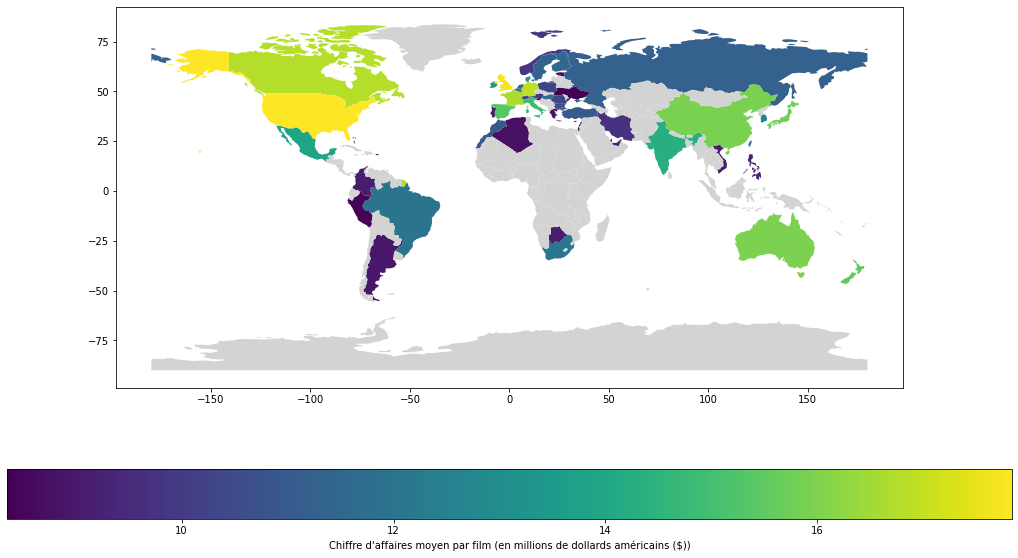

In [1055]:
world_movies.plot(
    column="Mean revenue",
    legend=True,
    legend_kwds={'label': "Chiffre d'affaires moyen par film (en millions de dollards américains ($))",
                        'orientation': "horizontal"},
    figsize=(18, 10),
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    },
);

Plus la coloration d'un pays tend vers le jaune/vert, plus le chiffre d'affaires des films qu'il produit est élevé. A l'inverse, plus sa coloration tend vers le violet, plus les films qu'il produits ont un chiffre d'affaire bas.\
Sans surprise, on remarque que les Etats-Unis, le Canada, la Chine, l'Europe de l'Ouest (particulièrement la France et le Royaume-Uni) sont en position dominante.\
Le Mexique également semble être un producteur de film très apprécié, qui générent des revenus élevés.\
On s'attend donc à pouvoir dessiner un modèle dans lequel le pays de production du film compte : plus le pays est développé et/ou riche, plus le film qu'il produit a de chance de rapporter gros en termes de chiffre d'affaires.

----------------------------------------------------------------------------------------------------------------

# Modélisation

## Preprocessing

On utilise le dataset le plus propre "df_ter", travaillé prélablement, duquel on retire les NaNs pour pouvoir créer un algorithme de modélisation.

In [954]:
df_4=df_ter.copy()
df_4.head(3)

budget  popularity    revenue  runtime  vote_average  vote_count  \
0  190000000     213.259  156497322      148         6.592        4262   
1   63000000      77.938  463517383      136         8.193       22288   
2  150000000      40.939  738599701      138         7.025        9385   

   release_year  release_month  release_day  Action  ...  United Kingdom  \
0        2021.0           12.0         16.0       1  ...               0   
1        1999.0            3.0         30.0       1  ...               0   
2        2003.0            5.0         15.0       1  ...               0   

   United States of America  Vietnam  b_to_c  en_original  ja_original  \
0                         1        0       1            1            0   
1                         1        0       1            1            0   
2                         1        0       1            1            0   

   fr_original  it_original  de_original  Others_original  
0            0            0            0                0  
1            0            0            0                0  
2            0            0            0                0  

[3 rows x 97 columns]

In [955]:
df_4.dropna(inplace=True)
print( str((1 - len(df_4)/len(df_ter))*100) + "% de NaN")

0.18382352941176405% de NaN


On fait le choix d'enlever les NaNs puisqu'ils concernent moins de 1% du dataset

In [956]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn import metrics

#### On présente ici différents Scaler : StandardScaler, MinMaxScaler et RobustScaler

MinMaxScaler transforme chaque variable $ X $ de telle sorte à être comprise entre 0 et 1 selon la formule suivante : 
$$ X_{scaled}=\frac{X - X_{min}}{X_{max} - X_{min}} $$

StandardScaler standardise chaque variable X : 
- la moyenne est nulle 
- l'écart type est égale à 1

    $$ X_{scaled}=\frac{X - \mu_X}{\sigma_X} $$

RobustScaler est insensible aux outliers 
On note IQR : l'écart interquartile (Q3 -Q1) 
On a : 

$$ X_{scaled}=\frac{X - médiane}{IQR} $$

Et la médiane est bcp moins sensible aux outliers

## Cas particuliers (1 seule itération) : RidgeCV, LassoCV, RandomForestRegressor

- On va utiliser plusieurs modèles. On va étudier les performances de chacun indépendemment. 
- Dans un second temps (sous-partie généralisation) on cherchera à comparer leurs performances et à voir quelles sont les features les plus importantes pour chaque modèle. On tâchera d'autom 
#### RidgeCV 

- On va s'intéresser ici à l'importance des features. 
- Le but est de conserver les features les plus importantes pour prédire le revenu de nos films. 
- On va réaliser une regression RIDGE et afficher les coefficients associés à chacune des variables. 

- Comme on l'a vu dans la partie analyse des données, les liens entre les variables sont plus importants lorsque nous travaillons en échelle log. Ainsi, nous passons les variables revenue et budget en log. 

In [957]:
df_4.revenue=np.log(df_4.revenue)
df_4.budget=np.log(df_4.budget)

- La première étape est de segmenter notre dataframe. On sépare notre target "y", à savoir le revenu, du reste du dataset "X". 
- Ensuite on segmente nos deux dataframe en 2 : train et test. 
- Ainsi on obtient $ X_{train}, X_{test}, y_{train}, y_{test} $

In [958]:
X=df_4.drop(['revenue'],axis=1)
y= df_4['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )
X_t=X_train.copy() #on utilisera cela plus tard pour l'importance des coefficients (X_t ne sera pas standardisé contrairement à X_train)

On va maintenant normaliser nos données à l'aide d'un scaler. On choisit RobustScaler qui est moins sensible aux outliers (valeurs extêmes)

In [959]:
scaler=RobustScaler()
    
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.fit_transform(X_test)

Par défaut, RidgeCV() utilise par défaut une Leave-One-Out cross-validation. 


#### On implémente également une fonction affichage qui permet d'évaluer la qualité de la prédiction grâce à différentes métriques 

In [908]:
def affichage(X_test,y_test, model):
    " Cette fonction nous permet de tracer les valeurs prédites vs les valeurs réelles "
    " De plus, on va accéder à toutes les métriques (MAE, MAPE, MSE, R2...) concernant cette prédiction "
    
    # On définit y_pred comme étant la prédiction de notre X_test avec le modèle tuné obtenu précédemment 
    y_pred = model.predict(X_test)


    fig, axs = plt.subplots( figsize=(8, 8))

    # On affiche les points de coordonnées (y_test, y_pred)
    plt.scatter(y_pred, y_test, marker = "." )

    # On affiche également la droite idéale : la prédiction est égale à la valeur réelle
    plt.plot([x for x in range(23)], color='g', marker = ".", label="y=x")


    # On va essayer ici de tracer la régression linéaire des valeurs réelles sur les valeurs prédites  

    #linregress() renvoie plusieurs variables de retour. On s'interessera 
    # particulierement au slope et intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
    print("slope : " + str(slope))
    print("intercept : " + str(intercept))

    def predict(x):
       return(slope * x + intercept)

    #la variable fitLine sera un tableau de valeurs prédites depuis la tableau de variables X
    fitLine = predict(y_test)
    plt.plot(y_test, fitLine, c='r', linestyle='--', label='regression linéaire')

    #plt.legend('Droite idéale')
    plt.title(f"Predictions vs Actual Values avec le modèle {model}", fontsize=18)
    plt.tight_layout()
    plt.xlim(10,22)
    plt.ylim(10,22)
    plt.legend()
    plt.xlabel('Predicted values', fontsize=12)
    plt.ylabel('Actual values', fontsize=12)
    plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")
    plt.show()

    print("____________________________________________________")
    print(f'model score R_2 on training data: {model.score(X_train, y_train)}')
    print(f'model score R_2 on testing data: {model.score(X_test, y_test)}')    #Les scores sont ici les R_2 
    print("__________________________________________________________________")
    print( "La Mean Absolute Percentage Error (MAPE) est de " + str(mean_absolute_percentage_error(y_test, y_pred)))
    print( "La Mean Absolute Error (MAE) est de " + str(mean_absolute_error(y_test, y_pred)))
    print( "La Mean Squared Error (MSE) est de " + str(mean_squared_error(y_test, y_pred)))
    print( "Le Explained Variance Score est de " + str(explained_variance_score(y_test, y_pred)))

slope : 0.7139016799870971
intercept : 4.993632283549493


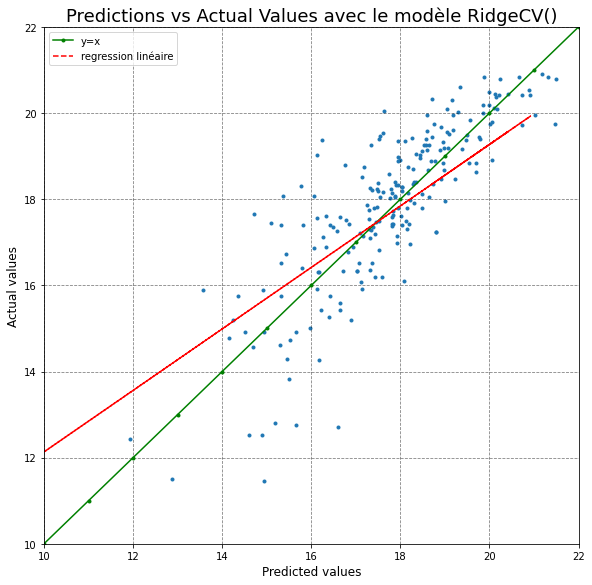

____________________________________________________
model score R_2 on training data: 0.6778557375406085
model score R_2 on testing data: 0.7157321786002938
__________________________________________________________________
La Mean Absolute Percentage Error (MAPE) est de 0.05132896383608733
La Mean Absolute Error (MAE) est de 0.8368935024106184
La Mean Squared Error (MSE) est de 1.2614616450133782
Le Explained Variance Score est de 0.7176917842792427


In [909]:
model=RidgeCV()
model.fit(X_train,y_train)

#predictions = model.predict(X_test)

affichage(X_test, y_test,model)

#print(f'model score on training data: {model.score(X_train, y_train)}')
#print(f'model score on testing data: {model.score(X_test, y_test)}')

#### On va afficher les coefficients de chaque variable : cela nous donne l'importance de chacune des variables

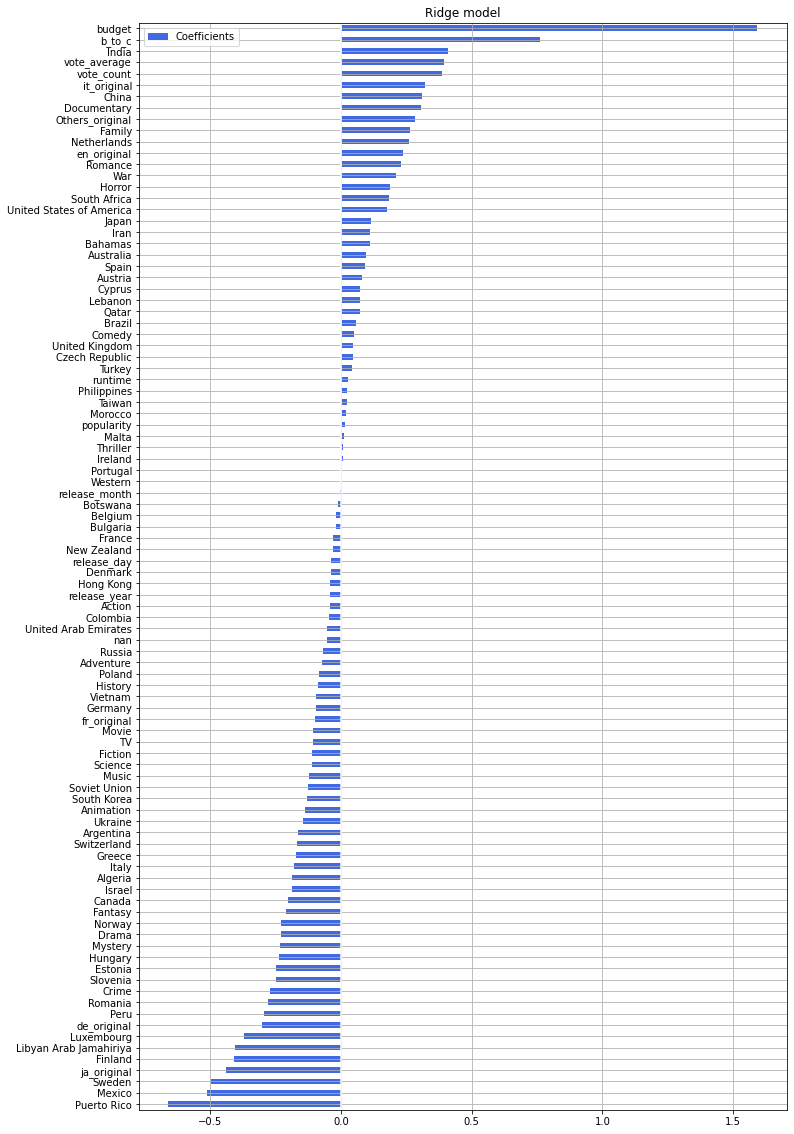

In [900]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_t.columns
)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Ridge model')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

### Régression Lasso

In [901]:
from sklearn.linear_model import LassoCV

slope : 0.719567820979454
intercept : 4.890792681519386


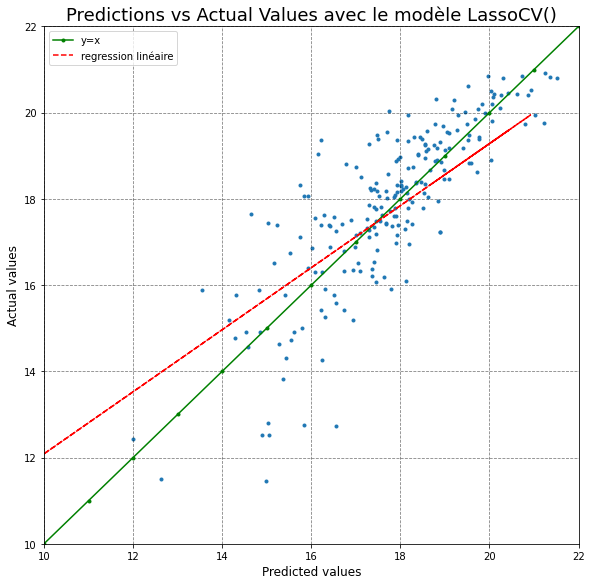

____________________________________________________
model score R_2 on training data: 0.6711406022107927
model score R_2 on testing data: 0.715681331028172
__________________________________________________________________
La Mean Absolute Percentage Error (MAPE) est de 0.05077203316876072
La Mean Absolute Error (MAE) est de 0.8302624714417697
La Mean Squared Error (MSE) est de 1.2616872852622742
Le Explained Variance Score est de 0.7177299536820112


In [910]:
model=LassoCV() #Par défaut LassoCV utilise une 5-fold cross-validation
model.fit(X_train,y_train)

#predictions = model.predict(X_test)

affichage(X_test, y_test,model)

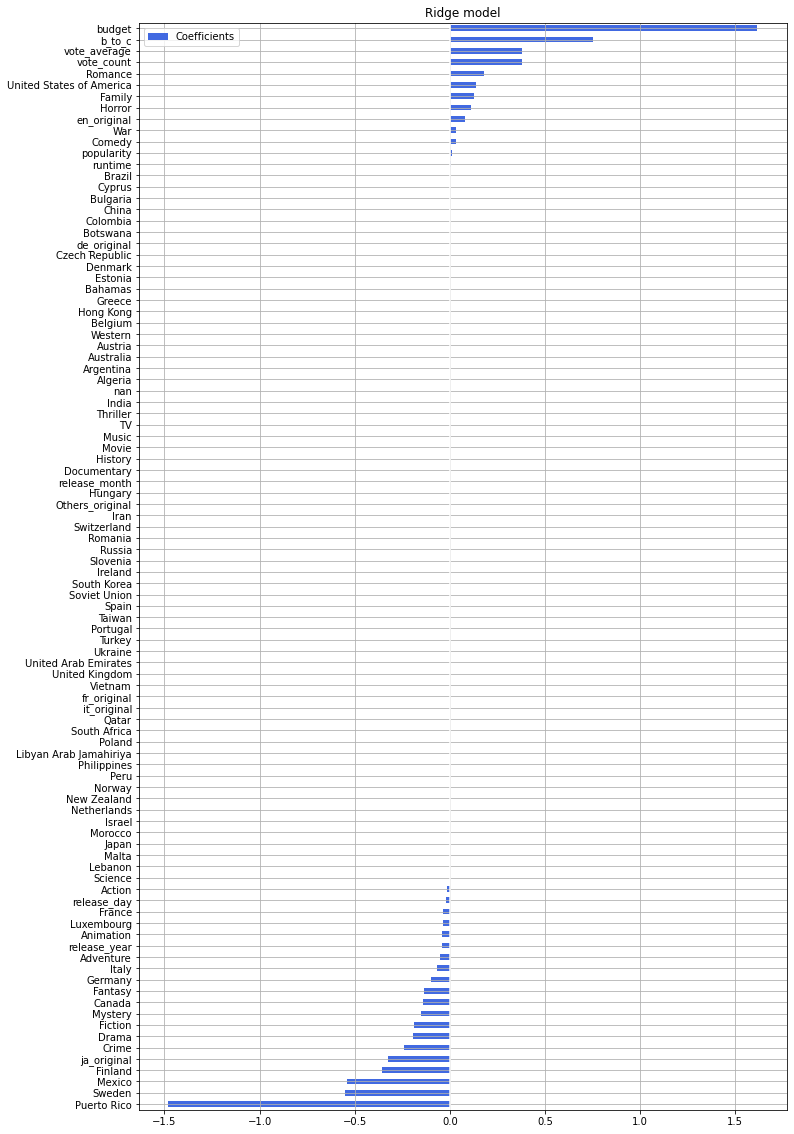

In [911]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_t.columns
)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Ridge model')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

### Random Forest Regressor

- On fait la même chose que précédemment mais avec un RandomForestRegressor

In [912]:
from sklearn.ensemble import RandomForestRegressor

slope : 0.6771593929063316
intercept : 5.707420397516392


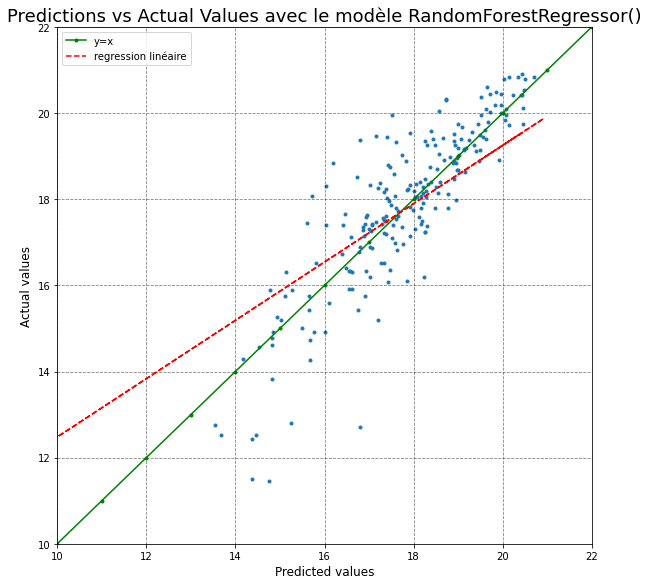

____________________________________________________
model score R_2 on training data: 0.9596186795264277
model score R_2 on testing data: 0.7617247918173551
__________________________________________________________________
La Mean Absolute Percentage Error (MAPE) est de 0.043965543169246224
La Mean Absolute Error (MAE) est de 0.6933485515438984
La Mean Squared Error (MSE) est de 1.057365672273362
Le Explained Variance Score est de 0.7619664740036571


In [913]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

affichage(X_test, y_test,model)

Le score obtenu sur le testing data n'est pas très satisfaisant. On va essayer d'améliorer ce score. 

In [914]:
importances = model.feature_importances_

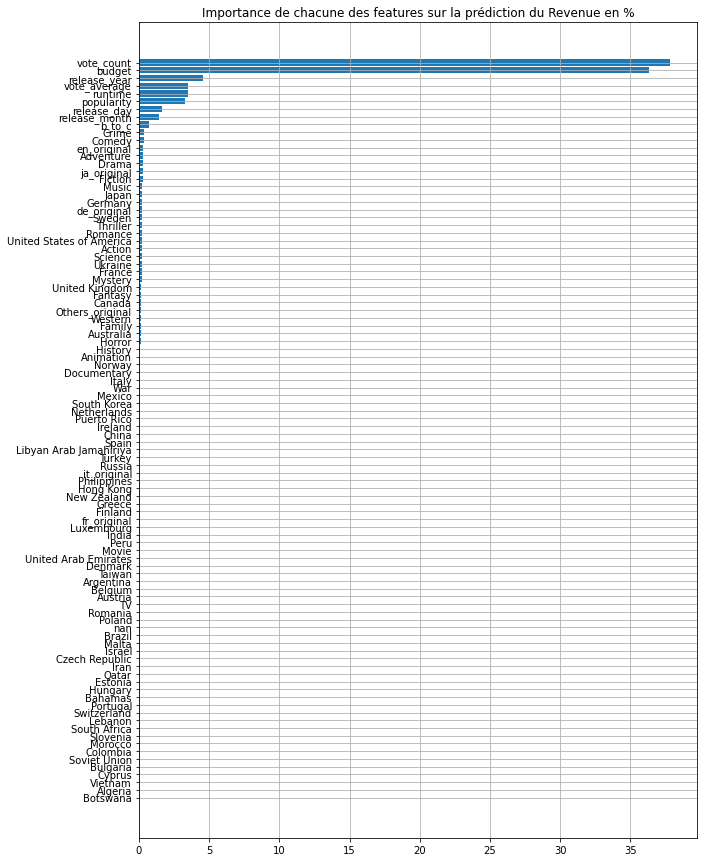

In [915]:
indices = np.argsort(importances)


fig, ax = plt.subplots(figsize=(10,15))
ax.barh(range(len(importances)), importances[indices]*100)
ax.set_yticks(range(len(importances)), colors='royalblue')
_ = ax.set_yticklabels(np.array(X_t.columns)[indices])
plt.grid()
plt.title("Importance de chacune des features sur la prédiction du Revenue en %")
plt.show()

In [916]:
Feature_selected= list(np.array(X_t.columns)[indices][-10:])
Feature_selected.append('revenue')
Feature_selected

['Crime',
 'b_to_c',
 'release_month',
 'release_day',
 'popularity',
 'runtime',
 'vote_average',
 'release_year',
 'budget',
 'vote_count',
 'revenue']

##### On fait le choix de ne conserver que les 10 variables les plus importantes pour la prédiction de notre revenu. 

In [917]:
df_5=df_ter[Feature_selected].copy()
#df_5

## Généralisation : Comparaison des différents modèles (sans tuning dans un 1er temps)

In [918]:
def test(models, data, scaler, iterations):
    "Cette fonction permet d'automatiser la modélisation et de réaliser plusieurs itérations"
    "On accède directement à la comparaison des modèles"
    
    data.dropna(inplace=True) #on enlève les valeurs manquantes du dataset
    
    data.revenue=np.log(data.revenue)
    data.budget=np.log(data.budget)
    
    X= data.drop(['revenue'],axis=1)
    y= data['revenue']
    
    results = {}
    for i in tqdm(models):
        r2_train = []
        r2_test = []
        for j in range(iterations):
            
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size= 0.1)
            # on normalise les données
            X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
            X_test= scaler.fit_transform(X_test)
            
            
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [965]:
df_4=df_ter.copy()
models={" Lasso" : LassoCV(),
       " Ridge" : RidgeCV(),
       "RandomForest": RandomForestRegressor()}
test(models, df_4, RobustScaler(), iterations = 10)

100%|██████████| 3/3 [00:26<00:00,  9.00s/it]


Lasso     Ridge  RandomForest
0  0.679123  0.683307      0.961433
1  0.630576  0.626882      0.649314

Le RandomForestRegressor est le modèle ayant les meilleurs résultats sur tous les plans : 
- meilleur $ R^2 $ 
- plus faible MAPE, MAE et MSE

Ainsi, pour la dernière partie de notre projet, on va s'intéresser au tuning des hyperparamètres pour ce modèle. 

In [967]:
df_5=df_ter[Feature_selected].copy()
models={" Lasso" : LassoCV(),
       " Ridge" : RidgeCV(),
       "RandomForest": RandomForestRegressor()}
test(models, df_5, RobustScaler(), iterations = 10)

100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


Lasso     Ridge  RandomForest
0  0.654198  0.653945      0.961353
1  0.593930  0.617401      0.629220

## Tuning des hyperparamètres pour le RandomForest 

In [968]:
from sklearn.model_selection import GridSearchCV

### RandomForest avec GridSearchCV

##### Dans cette sous partie on va essayer de "tuner" les paramètres pour augmenter les performances de notre modèle
- pour cela nous allons utiliser GridSearchCV. GridSearchCV, by default, makes K=3 cross validation

Dans un premier temps on reprend le code de la partie précédente : 

In [969]:
df_4=df_ter.copy()
df_4.dropna(inplace=True) #on enlève les valeurs manquantes du dataset

df_4.revenue=np.log(df_4.revenue)
df_4.budget=np.log(df_4.budget)

X=df_4.drop(['revenue'],axis=1)
y= df_4['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )
X_t=X_train.copy() #on utilisera cela plus tard pour l'importance des coefficients (X_t ne sera pas standardisé contrairement à X_train)

scaler=RobustScaler()
    
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.fit_transform(X_test)

On va proposer différents paramètres à tester grâce au GridSearchCV 

In [970]:
parameters = {
    'n_estimators': [50,100,150, 200, 250, 300, 400 ,500],
    'max_depth': [2,3,4,5],
}
regr = RandomForestRegressor(random_state=0)

grid = GridSearchCV(regr, parameters)
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 400,
                                          500]})

On affiche les meilleurs paramètres retenus par notre GridSearchCV

In [972]:
grid.best_params_

{'max_depth': 5, 'n_estimators': 250}

In [973]:
model=grid.best_estimator_
model.score(X_test, y_test)

0.7733862680222402

slope : 0.711612300030773
intercept : 4.918981274014341


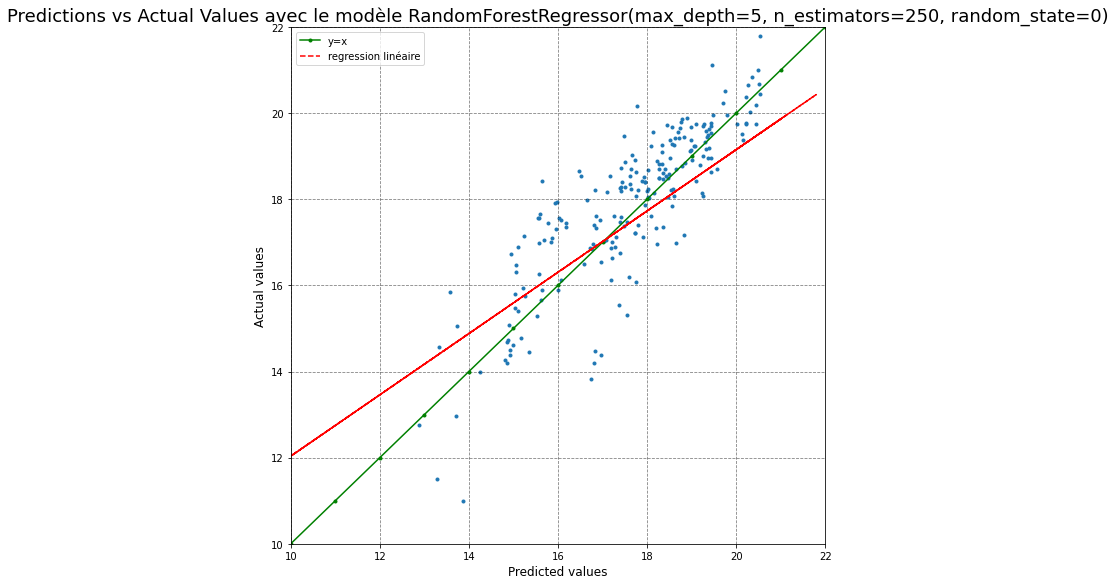

____________________________________________________
model score R_2 on training data: 0.7662258499639314
model score R_2 on testing data: 0.7733862680222402
__________________________________________________________________
La Mean Absolute Percentage Error (MAPE) est de 93573115659299.6
La Mean Absolute Error (MAE) est de 0.8519750579162465
La Mean Squared Error (MSE) est de 1.5521280126055061
Le Explained Variance Score est de 0.776700440386613


In [974]:
affichage(X_test,y_test, model)

In [975]:
df_4=df_ter.copy()
model_tuned = { 'RF_tuned' : model }
test(model_tuned, df_4, RobustScaler(), iterations = 10)

100%|██████████| 1/1 [00:22<00:00, 22.29s/it]


RF_tuned
0  0.781602
1  0.634066

In [977]:
df_4=df_ter[Feature_selected].copy()
model_tuned = { 'RF_tuned' : model }
test(model_tuned, df_4, RobustScaler(), iterations = 10)

100%|██████████| 1/1 [00:16<00:00, 16.20s/it]


RF_tuned
0  0.778593
1  0.656006

On affiche l'importance des features dans la modélisation. 

slope : 0.6083114854146456
intercept : 6.924471733554213


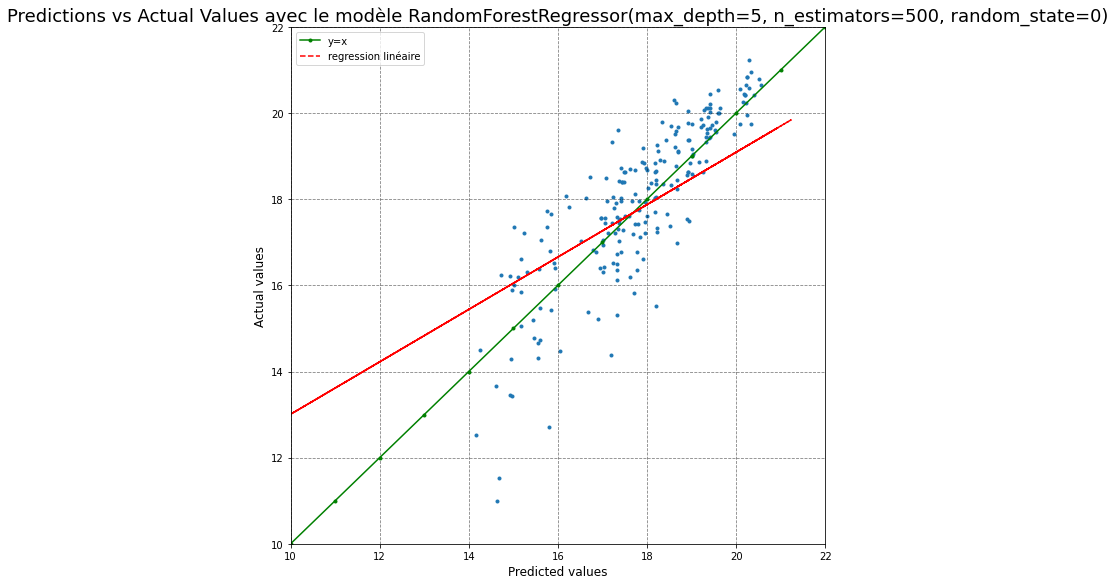

____________________________________________________
model score R_2 on training data: 0.773431260036837
model score R_2 on testing data: 0.7356227643748652
__________________________________________________________________
La Mean Absolute Percentage Error (MAPE) est de 162465519197619.97
La Mean Absolute Error (MAE) est de 0.8407434202253056
La Mean Squared Error (MSE) est de 1.721381779669844
Le Explained Variance Score est de 0.735788861800464


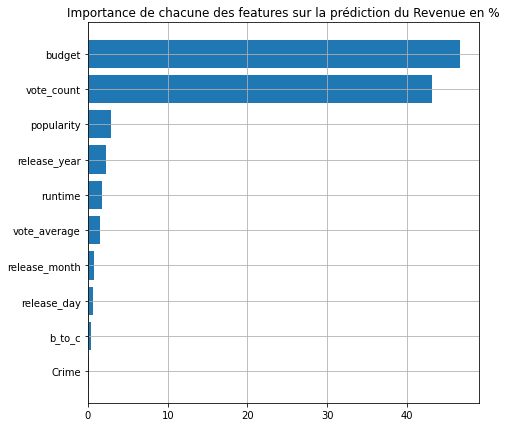

In [1056]:
df_4=df_ter[Feature_selected].copy()

df_4.dropna(inplace=True) #on enlève les valeurs manquantes du dataset

df_4.revenue=np.log(df_4.revenue)
df_4.budget=np.log(df_4.budget)

X=df_4.drop(['revenue'],axis=1)
y= df_4['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )
X_t=X_train.copy() #on utilisera cela plus tard pour l'importance des coefficients (X_t ne sera pas standardisé contrairement à X_train)

scaler=RobustScaler()
    
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.fit_transform(X_test)

parameters = {
    'n_estimators': [50,100,150, 200, 250, 300, 400 ,500],
    'max_depth': [2,3,4,5],
}
regr = RandomForestRegressor(random_state=0)

grid = GridSearchCV(regr, parameters)
grid.fit(X_train, y_train)

model=grid.best_estimator_

affichage(X_test,y_test, model)


importances = model.feature_importances_
indices = np.argsort(importances)


fig, ax = plt.subplots(figsize=(7,7))
ax.barh(range(len(importances)), importances[indices]*100)
ax.set_yticks(range(len(importances)), colors='royalblue')
_ = ax.set_yticklabels(np.array(X_t.columns)[indices])
plt.grid()
plt.title("Importance de chacune des features sur la prédiction du Revenue en %")
plt.show()